In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import os

global CDMS_SUPERSIM
CDMS_SUPERSIM = os.environ['CDMS_SUPERSIM']

In [2]:
def traceFit(detname, file, event, chan, plot=False):
    bins, I0, trace, PhononE = getTraces(file, event, chan)
    
    #### Obtain figures of merit measurements for trace and template ####
    a, t_r, t_f, offset = trace_fitting(bins, trace)

    titleName = detname if detname else "Trace"
    print(f'# {titleName} Trace shape parameters (to generate templates)')
    print(f'I0\t\t{I0:.4e} microampere')
    print(f'IversusE\t{max(trace)/PhononE:.4e} microampere/eV')
    print(f'riseTime\t{t_r:.4e} us')
    print(f'fallTime\t{t_f:.4e} us')

    template = getTemplate(detname, chan)
    if plot: trace_overlay(bins, trace, template, a, t_r, t_f, offset)

In [3]:
def getTraces(file, event, chan):
    import ROOT #imported later so that ROOT does not display its own usage function

    # User gives absolute path of ROOT file and the g4dmcTES tree is opened
    g4dmcTES = ROOT.RDataFrame('G4SimDir/g4dmcTES', file, ['Trace', 'BinWidth', 'T0'])\
    .Filter("DataType=={} & EventNum=={} & ChanNum=={}".format(0, event, chan))\
    .AsNumpy(['Trace', 'BinWidth', 'T0'])
    
    g4dmcEvent = ROOT.RDataFrame('G4SimDir/g4dmcEvent', file, ['PhononE'])\
    .Filter("EventNum=={}".format(event))\
    .AsNumpy(['PhononE'])
    trace = np.array([np.array(v).tolist() for v in g4dmcTES['Trace'][0]])
    PhononE  = g4dmcEvent['PhononE'][0][chan]   # Single channel collected energy
    T0       = g4dmcTES['T0'][0]                # start time of trace
    numBins  = len(trace)                       # number of bins
    BinWidth = g4dmcTES['BinWidth'][0]          # width of bin in nanoseconds

    # use those three values with the np.arange() function to create binning array
    bins      = np.arange(T0, T0 + numBins * BinWidth, BinWidth) * 1e-3 #ns -> us
    start     = bins.tolist().index(0)
    I0        = np.mean(trace[0: start])
    trace     = max(trace) - trace
    
    return bins, I0, trace, PhononE

In [4]:
def getTemplate(detname, chan):
    templatePath = CDMS_SUPERSIM + "/CDMSgeometry/data/dmc/" + detname + "/TESTemplates"
    if not os.path.isfile(templatePath): return None
    
    HVeV_TEStemp = pd.read_csv(templatePath,sep="\t")
    template = HVeV_TEStemp.loc[chan,"Traces"].split()
    template = np.array([float(i) for i in template])
    
    return template

In [5]:
def fittingRange(trace, cut=0.2):
    """Return starting and ending points for pulse fit, corresponding to 'cut' height
       on either side of peak.  Assumes trace is baseline-subtracted and flipped!"""
    peak = max(trace)          # Peak Height
    ipeak = list(trace).index(peak)

    ilo = np.nonzero(trace[:ipeak]<=cut*peak)[0][-1]          # End of rising edge
    ihi = ipeak+np.nonzero(trace[ipeak:]<=cut*peak)[0][0]     # Start of falling tail
    return ilo, ihi

In [6]:
def pulseShape(x, a, t_r, t_f, offset):
    return a*(np.exp(-(x-offset)/t_f)-np.exp(-(x-offset)/t_r))

In [7]:
def fittingGuess(bins, trace):
    """Returns initial guesses for the rise and fall times to feed into curve_fit"""
    peak = max(trace)
    ipeak = list(trace).index(peak)
    
    # Rise time: look for two e-foldings on rising side
    rlo = np.nonzero(trace[:ipeak]<=0.1*peak)[0][-1]    # End of rising edge
    rhi = np.nonzero(trace[:ipeak]<=0.2*peak*np.e)[0][-1]
    riseGuess = (bins[rhi]-bins[rlo])
    
    # Fall time: look for two e-foldings on falling side
    flo = np.nonzero(trace[ipeak:]<=0.8*peak)[0][0]     # Start of falling tail
    fhi = np.nonzero(trace[ipeak:]<=0.4*peak/np.e)[0][0]
    fallGuess = (bins[fhi]-bins[flo])/2

    # Analytic peak position is where d/dt of pulse shape is zero
    # ==> t_peak = tR * ln[(tF+tR)/tR]
    tpeak = riseGuess * np.log((fallGuess+riseGuess)/riseGuess)
    offsetGuess = bins[ipeak] - tpeak
    
    # Scale factor should be max of shape scaled by actual peak value
    pmax = pulseShape(tpeak, 1., riseGuess, fallGuess, 0.)
    scaleGuess = peak / pmax

    return scaleGuess, riseGuess, fallGuess, offsetGuess

In [8]:
def trace_fitting(bins, trace):
    start, end = fittingRange(trace)
    guess = fittingGuess(bins, trace)     # List of parameters in order [a,t_r,t_f,offset]
    
    lower = 0.1*np.array(guess)
    upper = 5.*np.array(guess)
    bounds = (lower, upper)
    
    params, _ = curve_fit(pulseShape, bins[start:end], trace[start:end], p0=guess, bounds=bounds)
    a, t_r, t_f, offset = params
    
    return a, t_r, t_f, offset

In [9]:
def trace_overlay(bins, trace, template, a, t_r, t_f, offset):
    start, end = fittingRange(trace)
    
    fig, axes = plt.subplots(1, 2, figsize=(12*0.7, 4*0.7), dpi=200)
    for plot in range(2):
        currentAxis = axes.flatten()[plot]

        if template is not None:
            currentAxis.plot(bins, template*max(trace), lw=1, ls='--', color='black', label='Template')

        currentAxis.plot(bins, trace, lw=1, ls='-', color='red', label='Simulation')       
        currentAxis.plot(bins[start:end], pulseShape(bins[start:end], a, t_r, t_f, offset), label='Fit')
        currentAxis.set_xlabel(r"Time [$\mathrm{\mu s}$]")
        currentAxis.set_ylabel(r"Amplitude [$\mathrm{\mu A}$]")
        currentAxis.legend()
        currentAxis.set_xlim([-100, -10][plot], [1000, 300][plot])
        currentAxis.set_yscale(['log', 'linear'][plot])
        
    plt.tight_layout()

In [10]:
file = 'data/HVeV_fits/NF-C-1.95eV_51231210_000000.root'
event = 0
chanID = 1
bins, I0, trace, PhononE = getTraces(file, event, chanID)
scale,rise,fall,offset = fittingGuess(bins, trace)
print("scale ",scale," rise ",rise," fall ",fall," offset ",offset)

Welcome to JupyROOT 6.24/06
scale  0.13948799551303104  rise  11.200000000000003  fall  53.19999999999982  offset  22.808961626136327


# NF-C Trace shape parameters (to generate templates)
I0		8.1407e+00 microampere
IversusE	1.4675e-03 microampere/eV
riseTime	2.8157e+01 us
fallTime	3.7081e+01 us


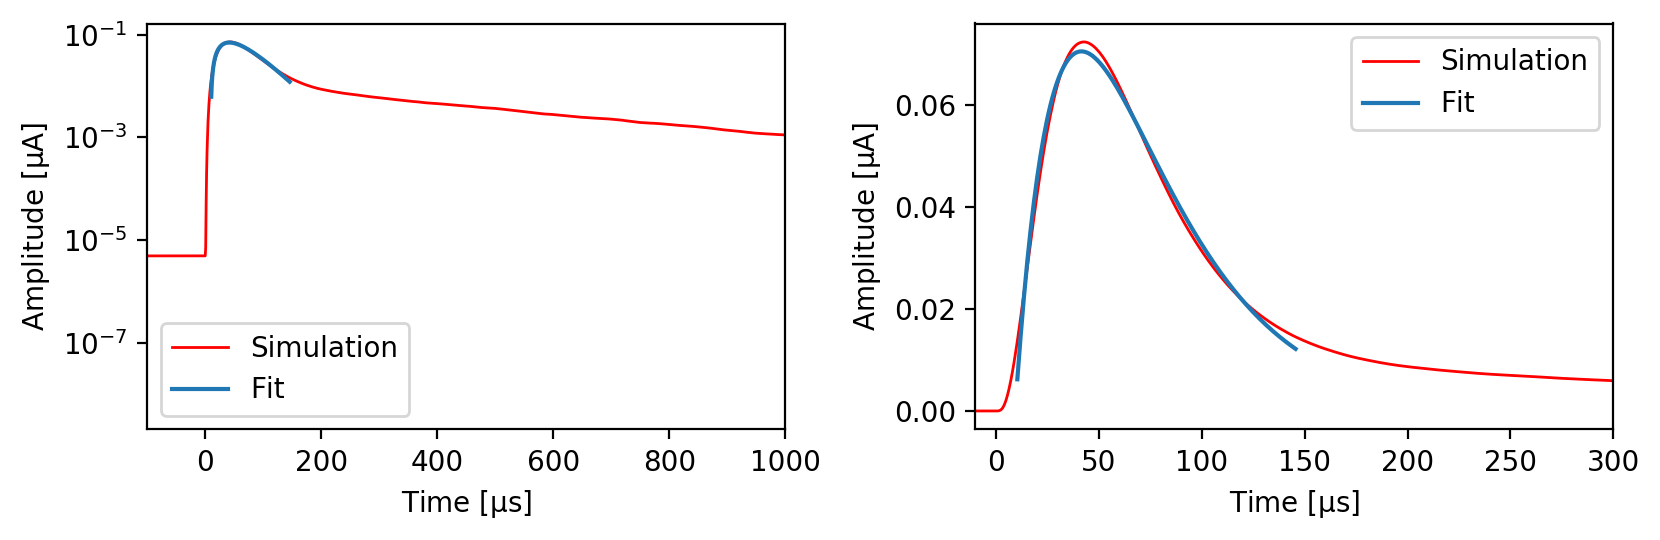

In [13]:
###file = 'HVeV_TraceMeasurement/HVeV_Laser_1_51231204_000000.root'
file = 'data/HVeV_fits/NF-C-1.95eV_51231210_000000.root'
event = 0
chanID = 1

traceFit('NF-C', file, event, chanID, plot=True)

In [12]:
plt.savefig("NF-C_traceFit.eps", format='eps')
plt.savefig("NF-C_traceFit.png")

<Figure size 432x288 with 0 Axes>